### Image Classification with Tensorflow and Triton Inference Server on NVIDIA AI Enterprise

##### What is Image Classification?

Image Classification is a process of identification and grouping of images into categories or classes using computer vision techniques. Over the years, these techniques have improved and now deep learning algorithms are the most accurate methods for this task.

##### Transfer Learning

Training a large neural network from scratch is computationally intensive and usually requires quite a bit of hand holding, from weight initialization to tuning hyperparameters like learning rate etc. Transfer learning solves this issue. Here, we use a neural network that is already trained on a large amount of data, and so is generalized enough such that it can be finetuned to produce good results on specific use cases.

##### Libraries and the Dataset

We will be using Stanford Online Product dataset available <a href="https://cvgl.stanford.edu/projects/lifted_struct/" target="_blank">here</a>. Stanford Online Products (SOP) dataset has 22,634 classes with 120,053 product images. The first 11,318 classes (59,551 images) are split for training and the other 11,316 (60,502 images) classes are used for testing. The dataset contains images of classes available on your regular e-commerce websites.

#### Workflow
In this portion of the lab, the machine learning workflow is explored:

* Examine and understand data
* Build an input pipeline
* Build the model
* Train the model
* Test the model
* Save the model into Triton Inference Server format

#### Step #1: Import libraries

Import Keras and Tensorflow libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### Step #2: Extract the dataset

The dataset is already available inside the environment as a zip file. We will extract it to a folder below.

In [2]:
import zipfile
with zipfile.ZipFile('/dataset/Stanford_Online_Products.zip', 'r') as zip_ref:
    zip_ref.extractall()

#### Step #3: Initialize the Dataset Image width, height and the batch size

Since, We will be using a pretrained Mobilenet model which accepts images of size (160,160,3) so the dataset height and width is set to that.

In [3]:
batch_size = 32
img_height = 160
img_width = 160

#### Step #4: Create a train and validation and test dataset
Using the Image sizes above, We will create training and validation datasets with an 80-20 split. Then create a test dataset from the validation set using every 5th image. We will load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. 

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "Stanford_Online_Products",
  validation_split=0.2,
  subset="training",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 120053 files belonging to 12 classes.
Using 96043 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "Stanford_Online_Products",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 120053 files belonging to 12 classes.
Using 24010 files for validation.


In [6]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

#### Step-5: Data Visualization
Now, let's look at the class names and few images of the products. 

In [7]:
class_names = train_ds.class_names
print(class_names)

['bicycle_final', 'cabinet_final', 'chair_final', 'coffee_maker_final', 'fan_final', 'kettle_final', 'lamp_final', 'mug_final', 'sofa_final', 'stapler_final', 'table_final', 'toaster_final']


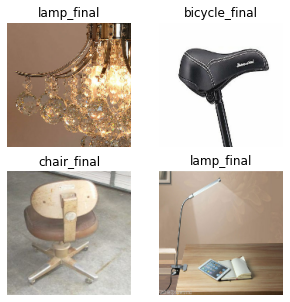

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Step-6: Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = len(class_names)

#### Step-7 : Use data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Step -8 : Preprocess the images to mobilenet format.
In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#### Step - 9 :  Download Mobilenet model
You will create the base model from the MobileNet V2 model developed at Google. This model has been pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe.

In [12]:
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Next, we will check the output size of the feature extractor before we attach a classification head.

In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


The mobilenet feature extractor has a size of 5x5x1280 convolutions. We now to need to average the convolutions values of the convolution layers into a single dimensional value so that it can be attached to a classification head.

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Next, we connect the classification head to the mobile net feature extractor with the output layer equal to the number of classes. 

In [15]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 12)


#### Step-10 : Build the model
Here we build a model by chaining together the data augmentation, preprocessing, base_model and feature extractor layers using the Keras Functional API.

In [16]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Step-11: Compile the model
Prior to training the model we compile the it. Use the tf.keras.losses.SparseCategoricalCrossentropy loss because it is a multiclass classification. We will also pass the from_logits=True argument since the model provides a linear output.

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

#### Step-12 : Train the model
Now we will set the number of epochs used to train the model and then start the training.  We will set the number of epochs to 10, this hyperparameter defines the number of times that the learning algorithm will work through the entire training data set.  NOTE:  Training will take about an hour to complete. 

In [18]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(val_ds)

601/601 [==============================] - 8s 11ms/step - loss: 3.0458 - sparse_categorical_accuracy: 0.0932


In [19]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
3002/3002 [==============================] - 201s 64ms/step - loss: 1.0523 - sparse_categorical_accuracy: 0.6502 - val_loss: 0.8519 - val_sparse_categorical_accuracy: 0.7277
Epoch 2/10
3002/3002 [==============================] - 188s 63ms/step - loss: 0.7987 - sparse_categorical_accuracy: 0.7319 - val_loss: 0.6839 - val_sparse_categorical_accuracy: 0.7726
Epoch 3/10
3002/3002 [==============================] - 189s 63ms/step - loss: 0.6922 - sparse_categorical_accuracy: 0.7674 - val_loss: 0.6092 - val_sparse_categorical_accuracy: 0.7952
Epoch 4/10
3002/3002 [==============================] - 188s 63ms/step - loss: 0.6162 - sparse_categorical_accuracy: 0.7909 - val_loss: 0.8150 - val_sparse_categorical_accuracy: 0.7366
Epoch 5/10
3002/3002 [==============================] - 184s 61ms/step - loss: 0.5524 - sparse_categorical_accuracy: 0.8133 - val_loss: 0.5422 - val_sparse_categorical_accuracy: 0.8183
Epoch 6/10
3002/3002 [==============================] - 184s 61ms/step - lo

#### Step - 13 : Learning curves
Now that we have trained the model, let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor. This will allow us to understand if the model is overfit (overtrained) or underfit (unable to learn patterns in data properly).   

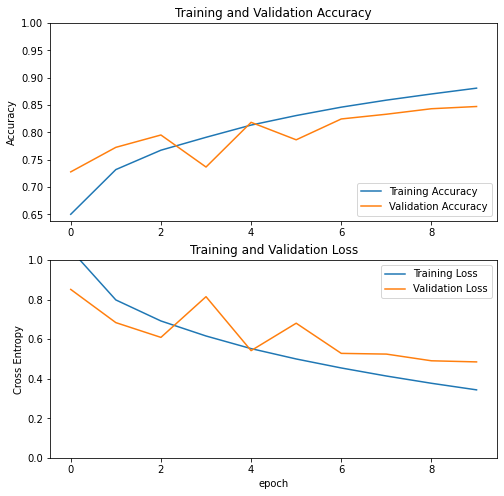

In [20]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Step-14 : Check accuracy on the test set
Finally, We will verify the performance of the model on new data using test set which we created in step-4

In [21]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

150/150 [==============================] - 2s 12ms/step - loss: 0.5127 - sparse_categorical_accuracy: 0.8408
Test accuracy : 0.840833306312561


#### Step-15: Visualize test images and predictions
Let's take a few examples from the test dataset to check how our model has performed on them. Comparing the predicted class names with image labels above, we notice that our model is able to predict the correct answer in most of the cases and gets a few misclassifications. The model accuracy can be further improved by tuning the model hyperparameters.

Predictions:
 [ 3  6  2  2  1  6  5 11  8  9  7 10  7  8 10  6  5  5  3  0  0  2  4  1
 10  5  0  1  6 10  5  0]
Labels:
 [10  6  2 10  1  6  5 10  8 10  7  2  7  8 10  6  5  5  3  0  0  2  0  1
 10  5  0  1  9 10  5  0]


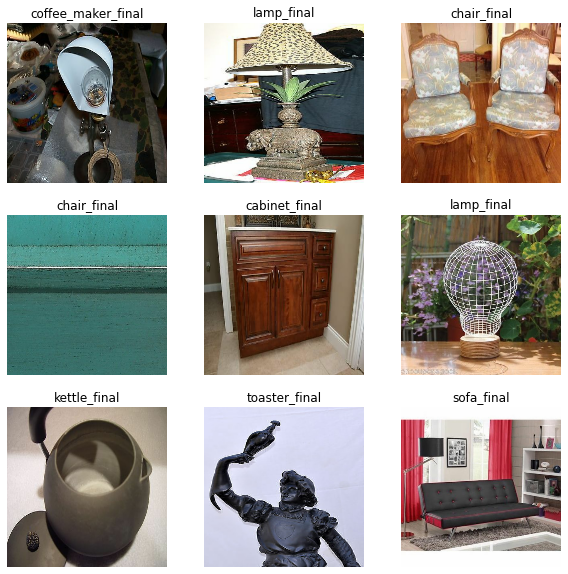

In [22]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = np.argmax(predictions, axis=1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")



### SAVE THE TRAINED MODEL FOR TRITON INFERENCE SERVER
Now that you have has successfully trained a model, the next step is to save the model in Triton Inference Server format so that you can deploy the model in the next part of this lab. 

##### TRITON INFERENCE SERVER
Triton Inference Server simplifies the deployment of AI models by serving inference requests at scale in production. It lets teams deploy trained AI models from any framework (TensorFlow, NVIDIA® TensorRT, PyTorch, ONNX Runtime, or custom) in addition to any local storage or cloud platform GPU- or CPU-based infrastructure (cloud, data center, or edge).

##### MODEL REPOSITORY
The model repository is a directory where we store the models deployed by the Triton Inference Server for Inference. A model repository is a folder that has the structure below. For more information about the Triton model, repository format, see below


```
<model-repository-path>/
    <model-name>/
      [config.pbtxt]
      [<output-labels-file> ...]
      <version>/
        <model-definition-file>
      <version>/
        <model-definition-file>
```

#### TensorFlow Models
TensorFlow saves models in one of two formats: GraphDef or SavedModel. Triton supports both formats.

A TensorFlow GraphDef is a single file that by default must be named model.graphdef. A TensorFlow SavedModel is a directory containing multiple files. By default the directory must be named model.savedmodel. These default names can be overridden using the default_model_filename property in the model configuration.

A minimal model repository for a TensorFlow SavedModel model is:

```
<model-repository-path>/
    <model-name>/
      config.pbtxt
      1/
        model.savedmodel/
           <saved-model files>
```

#### Step - 1: Save the model in Triton Inference server model repository format

Lets save the model using model.save function in the format below. As explained previously this is the format the Triton Inference server uses to serve the model

```
triton_models/
    mobilenet_classifier/
      config.pbtxt
      labels.txt
      1/
        model.savedmodel/
           <saved-model files>
```

##### Jupyter notebook file system
The notebook that we see here are currently running on a container inside an NVIDIA AI Enterprise VM. The VMs /home/temp/ directory is mounted inside the container at /dataset directory. The triton_models directory which is at the /home/temp/triton_models inside the VM is mounted to /dataset/triton_models directory. We do this to get access to the dataset on the VM and also to save the triton model on the VM for later use. Below we save the triton model on VM.


In [23]:
model.save('/dataset/triton_models/mobilenet_classifier/1/model.savedmodel')

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /dataset/triton_models/mobilenet_classifier/1/model.savedmodel/assets


#### Model Configuration
Each model in a model repository must include a model configuration that provides required and optional information about the model. Typically, this configuration is provided in a config.pbtxt file specified as ModelConfig protobuf. 

A minimal model configuration must specify the platform and/or backend properties, the max_batch_size property, and the input and output tensors of the model.

Below is the model configuration for out mobilenet model, observe that the input dimensions are (160,160,3) and output dimensions is 12 i.e number of image classes.

Finally, we also include a labels.txt file which includes the names for all classes so that the client is able to know which class the integer output belongs to.

In [24]:
config = """
name: "mobilenet_classifier"
platform: "tensorflow_savedmodel"
max_batch_size: 1
input [
  {
    name: "input_2"
    data_type: TYPE_FP32
    format: FORMAT_NHWC
    dims: [ 160, 160, 3 ]
  }
]
output [
  {
    name: "dense"
    data_type: TYPE_FP32
    dims: [ 12 ]
    label_filename: "labels.txt"
  }
]
"""

labels = ['bicycle', 'cabinet', 'chair', 'coffee_maker', 
              'fan', 'kettle', 'lamp', 'mug', 'sofa', 'stapler', 
              'table', 'toaster']

In [25]:
print(config)


name: "mobilenet_classifier"
platform: "tensorflow_savedmodel"
max_batch_size: 1
input [
  {
    name: "input_2"
    data_type: TYPE_FP32
    format: FORMAT_NHWC
    dims: [ 160, 160, 3 ]
  }
]
output [
  {
    name: "dense"
    data_type: TYPE_FP32
    dims: [ 12 ]
    label_filename: "labels.txt"
  }
]



#### Step - 2: Save the model configuration
The final step is to save the model configuration within Triton’s model repository which is available locally to serve inference requests. 

In [26]:
file = open("/dataset/triton_models/mobilenet_classifier/labels.txt", "w")
file.writelines("%s\n" % l for l in labels)
file.close()

file = open("/dataset/triton_models/mobilenet_classifier/config.pbtxt", "w")
file.write(config)
file.close()

#### Step - 3: Shutdown Kernel
From the above Jupyter lab menu, click on **Kernel** pulldown and then **Shutdown Kernel**.

<img src='shutdown.png'/>